In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

import GPy

In [2]:
def plot_with_sigma(x_train, y_train, x, y, sigma, label):
    pyplot.plot(x, y, label=label)
    pyplot.fill_between(x.ravel(), y.ravel() - 2 * sigma.ravel(), y.ravel() + 2 * sigma.ravel(), alpha=0.2)
    pyplot.plot(x_train, y_train, 'om', markersize=8, label='Data')
    pyplot.legend()

# GPy

* Специальная библиотека для построения ГП моделей
* Большое количество различных ковариационных функций
* Различные наработки для построения ГП на больших выборках
* Удобна в использовании
* Развивается


In [3]:
import GPy
N = 50
noise_var = 0.05

np.random.seed(1)
x_train = np.linspace(0,10,50)[:,None]
k = GPy.kern.RBF(1)
y_train = np.random.multivariate_normal(np.zeros(N), k.K(x_train) + np.eye(N) * np.sqrt(noise_var)).reshape(-1,1)

 /home/yermek/.local/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


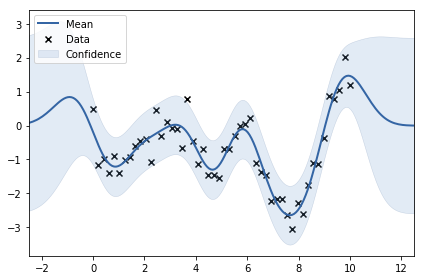

In [4]:
import GPy

kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=0.1)
model = GPy.models.GPRegression(x_train, y_train, kernel)
model.optimize()
model.plot()

# GPflow

* GPy, но с использованием TensorFlow
* Все возможности GPy
* Проста в использовании
* Плохая документация

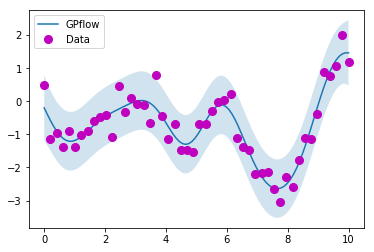

In [5]:
import GPflow

kernel = GPflow.kernels.RBF(input_dim=1, variance=1., lengthscales=0.1)
model = GPflow.gpr.GPR(x_train, y_train, kern=kernel)
model.optimize()

x = np.linspace(0, 10, 100).reshape(-1, 1)
y, sigma = model.predict_y(x)
pyplot.figure()
plot_with_sigma(x_train, y_train, x, y, np.sqrt(sigma), 'GPflow')
pyplot.show()

# PyMC3

* Мощный инструмент для построения вероятностных моделей
* Использует theano
* Много различных методов семплирования
* Необходимо разбираться в вероятностных моделях
* => Плохо подходит для построения ГП моделей


In [6]:
import pymc3 as pm
import theano.tensor as tt

# define kernel
cov = pm.gp.cov.ExpQuad(1, 0.3)
K = cov(x_train)
K_s = cov(x_train, x)
K_noise = K + 0.05 * np.eye(N) + 1e-12 * np.eye(N)

with pm.Model() as model:
    # The actual distribution of f_sample doesn't matter as long as the shape is right since it's only used
    # as a dummy variable for slice sampling with the given prior
    f_sample = pm.Flat('f_sample', shape=(N, ))

    # Likelihood
    y = pm.MvNormal('y', observed=y_train, mu=f_sample, cov=0.05 * tt.eye(N), shape=N)

    # Interpolate function values using noisy covariance matrix
    L = tt.slinalg.cholesky(K_noise)
    f_pred = pm.Deterministic('f_pred', tt.dot(K_s.T, tt.slinalg.solve(L.T, tt.slinalg.solve(L, f_sample))))

    # Use elliptical slice sampling
    ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K_noise)
    trace = pm.sample(2000, start=model.test_point, step=[ess_step], progressbar=False, random_seed=1)

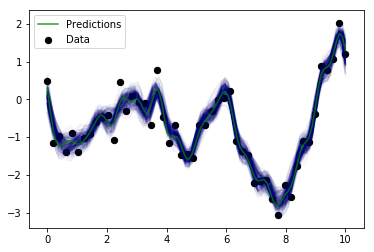

In [12]:
# Analytically compute posterior mean
L = np.linalg.cholesky(K_noise.eval())
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
post_mean = np.dot(K_s.T.eval(), alpha)

fig, ax = pyplot.subplots()
for idx in np.random.randint(1000, 2000, 500):
    ax.plot(x, trace['f_pred'][idx],  alpha=0.02, color='navy')
ax.scatter(x_train, y_train, s=40, color='k', label='Data');
ax.plot(x, post_mean, color='g', alpha=0.8, label='Predictions');
ax.legend();

# Scikit-learn

* Популярная библиотека для анализа данных и машинного обучения
* Гауссовские процессы есть, но только самые базовые вещи
* Сложнее настраивать параметры, легче переобучиться

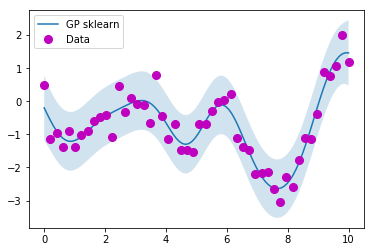

In [14]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e1)) + WhiteKernel(noise_level=0.05)
model = GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                 kernel=kernel)
model.fit(x_train, y_train)


x = np.linspace(0, 10, 100).reshape(-1, 1)
y, sigma = model.predict(x, return_std=True)
pyplot.figure()
plot_with_sigma(x_train, y_train, x, y, sigma, 'GP sklearn')
pyplot.show()

# Байсовская оптимизация

* В основном предназначена для оптимизация "тяжелых" функций
* Использует аппроксимацию целевой функции для ее оптимизации
* Учитывает ошибку аппроксимации

In [31]:
def f(x):
    return (6 * x - 2)**2 * np.sin(12 * x - 4)  


def lower_confidence_bound(x, model, coefficient=2):
    prediction, std = model.predict(x, return_std=True)
    return prediction.ravel() - coefficient * std.ravel()

def get_new_point(model):
    x_grid = np.linspace(0, 1, 200).reshape(-1, 1)

    lcb = lower_confidence_bound(x_grid, model, 2)

    new_point_index = np.argmin(lcb)
    x_new = x_grid[new_point_index]
    lcb = lcb[new_point_index]
    return x_new, lcb


def plot(x_train, y_train, model, x_new, lcb):
    x_grid = np.linspace(0, 1, 100).reshape(-1, 1)
    y_grid = f(x_grid)

    prediction, std = model.predict(x_grid, return_std=True)
    prediction = prediction.ravel()
    std = std.ravel()

    pyplot.figure(figsize=(8, 6))
    pyplot.plot(x_train, y_train, 'or', markersize=8, label='Training set')
    pyplot.plot(x_grid, y_grid, '--b', linewidth=2, label='True function')
    pyplot.plot(x_grid, prediction, '-k', linewidth=2, label='Approximation')
    pyplot.fill_between(x_grid.ravel(), prediction - 2 * std, prediction + 2 * std, alpha=0.3)
    pyplot.plot(x_new, lcb, 'og', markersize=10, label='New point')
    pyplot.ylim([-15, 20])
    pyplot.legend(loc='best')

def optimization_step(x_train, y_train, model):
    model.fit(x_train, y_train)

    x_new, lcb = get_new_point(model)
    plot(x_train, y_train, model, x_new, lcb)
    pyplot.show()
    
    x_train = np.vstack([x_train, x_new.reshape(-1, 1)])
    y_train = np.vstack([y_train, f(x_new).reshape(-1, 1)])
    return x_train, y_train

# Байсовская оптимизация

* В основном предназначена для оптимизация "тяжелых" функций
* Целевая функция может быть "черным ящиком"
* Использует аппроксимацию целевой функции для ее оптимизации
* Учитывает ошибку аппроксимации

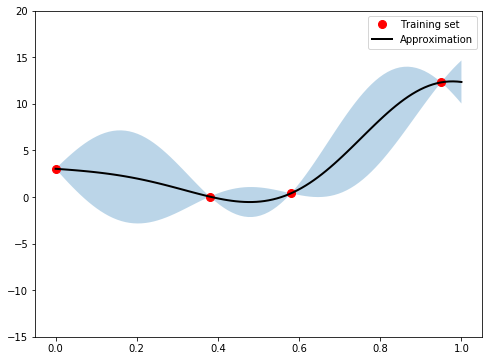

In [34]:
np.random.seed(239)

x_train = np.array([0.0, 0.58, 0.38, 0.95]).reshape(-1, 1)
y_train = f(x_train)

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-1, 1e1))
model = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
model.fit(x_train, y_train)

x_grid = np.linspace(0, 1, 100).reshape(-1, 1)
y_grid = f(x_grid)

prediction, std = model.predict(x_grid, return_std=True)
prediction = prediction.ravel()
std = std.ravel()

pyplot.figure(figsize=(8, 6))
pyplot.plot(x_train, y_train, 'or', markersize=8, label='Training set')
pyplot.plot(x_grid, prediction, '-k', linewidth=2, label='Approximation')
pyplot.fill_between(x_grid.ravel(), prediction - 2 * std, prediction + 2 * std, alpha=0.3)
pyplot.ylim([-15, 20])
pyplot.legend(loc='best')

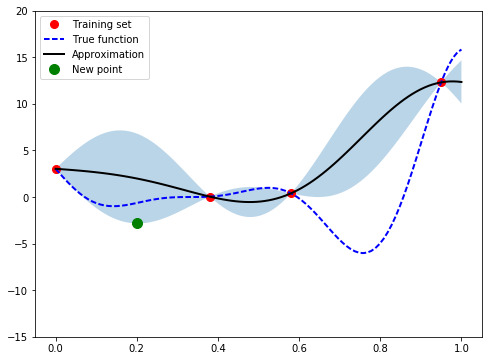

In [35]:
x_train, y_train = optimization_step(x_train, y_train, model)

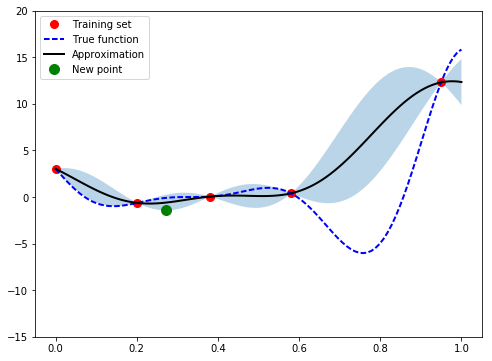

In [36]:
x_train, y_train = optimization_step(x_train, y_train, model)

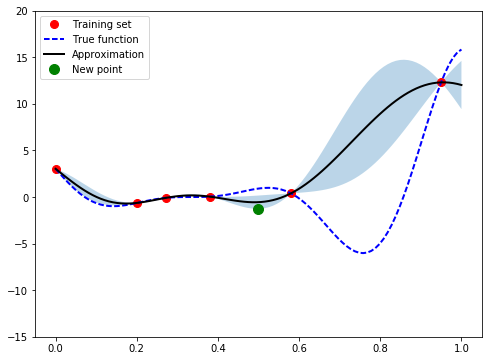

In [37]:
x_train, y_train = optimization_step(x_train, y_train, model)

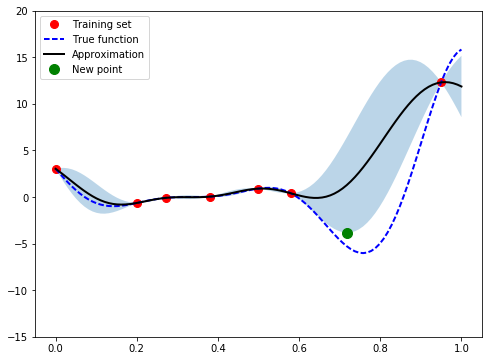

In [38]:
x_train, y_train = optimization_step(x_train, y_train, model)

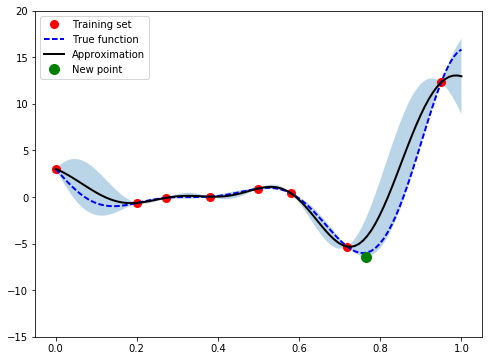

In [39]:
x_train, y_train = optimization_step(x_train, y_train, model)

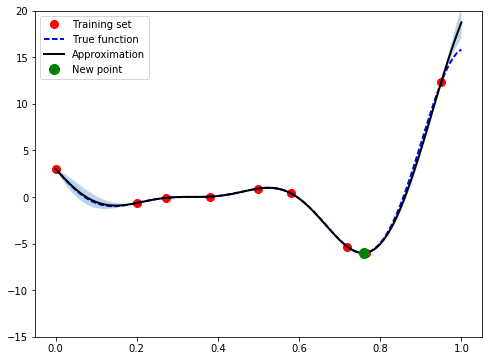

In [40]:
x_train, y_train = optimization_step(x_train, y_train, model)

# Summary

* Гауссовские процессы - вероятностная модель данных
* Позволяет решает широкий класс задач: регрессия, классификация, оптимизация, планирование эксперимента
* Требуется подбирать ядро в зависимости от задачи
* Высокая вычислительная сложность, однако существуют методы построения ГП для больших выборок